# 非線形SVMによる教師あり学習


---
## 目的
非線形SVM(Support Vector Machine)を用いて2つのサンプルを識別する．その後，交差検定法を用いて識別テストを行う．


## プログラムの動作
下記のプログラムを実行すると，`data/car.txt`と`data/human.txt`の2つ読み込む．次に，非線形SVMによる学習およびテストを交差検定法を用いて行う．最後に，識別率とグラフを表示する．


## プログラムの解説
プログラムを上から順番に解説していく．なお，今回は第5回と同じプログラムで識別器の定義を変更しただけであるため，細かい説明は省略する．わからないところがあれば第5回の解説を読み返すこと．様々な識別器を簡単に切り替えて使うことができるのもscikit-learnの利点である．

## 準備
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍する．

In [1]:
import gdown
gdown.download('https://drive.google.com/uc?id=1Li0sdp2loJ7rcZjtzIx7uGG3r6Vs62TO', 'car_human_data.zip', quiet=False)
!unzip -q -o car_human_data.zip
!mv car_human_data data
!ls -R ./data

Downloading...
From: https://drive.google.com/uc?id=1Li0sdp2loJ7rcZjtzIx7uGG3r6Vs62TO
To: /content/car_human_data.zip
100%|██████████| 3.83k/3.83k [00:00<00:00, 8.67MB/s]


./data:
car.txt  human.txt


## モジュールのインポート
初めに，必要なモジュールをインポートする．

In [2]:
from os import path
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection

## データの読み込み
次に，テキストファイルを読み込む．

In [3]:
in_txt1 = open(path.join('data', 'car.txt'))
in_txt2 = open(path.join('data', 'human.txt'))

car = np.asarray([(line.strip()).split('\t') for line in in_txt1], dtype=float)
print(car.shape)
human = np.asarray([(line.strip()).split('\t') for line in in_txt2], dtype=float)
print(human.shape)

(110, 2)
(382, 2)


## データのラベル付けと結合，交差検定法の準備
学習を行う前に，データがcarまたはhumanどちらのクラスに属するかラベル付けをする．また，交差検定法に使うオブジェクトを準備する．

In [4]:
car_y =  np.zeros(car.shape[0])
human_y = np.ones(human.shape[0])
X= np.r_[car, human]
y= np.r_[car_y, human_y]

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
print(X.shape, y.shape)

(492, 2) (492,)


## 学習と評価
for文で学習と評価をk回繰り返す．


In [8]:
scores = []
best_score = 0.0

for train, test in kfold.split(X):
    classifier = svm.SVC(C=2**12, kernel='rbf', gamma=2**-20, random_state=0)
    classifier.fit(X[train], y[train])
    preds = classifier.predict(X[test])
    score = metrics.accuracy_score(preds, y[test])
    scores.append(score)

    if score > best_score:
        best_classifier = classifier
        best_score = score

`classifier = svm.SVC(C=2**12, kernel='rbf', gamma=2**-20)`が識別器の定義となる．今回はlinearでないSVCとなる．主なパラメータとして`C`と`kernel`と`gamma`がある．

- `C`: 誤分類に対するペナルティ
- `kernel`: 利用するカーネル関数
- `gamma`: rbfカーネルを用いたときのガンマの値

カーネル関数とガンマについては後述する．直感的には，`C`は誤分類を厳しくチェックするかを決め，`gamma`はどれくらい複雑な曲線でクラスを分類するかを決める．これらのパラメータの値はうまく調整しなければならない．単に値を高くしておくだけではうまく識別できない．

### カーネル法
非線形のSVMは「カーネル法」と呼ばれる手法を用いる．この手法は，線形分離できない特徴点を線形分離可能な別の特徴空間に変換し，そこで線形分離を行い，最後に元の次元に戻すことで識別する．今回用いるrbfカーネル関数は次の式で表すことができる：

## 識別率の計算
得られたk個の結果を平均して，識別率を求める．

In [9]:
accuracy = (sum(scores) / len(scores)) * 100
msg = 'recognition rate: {accuracy:.2f}%'.format(accuracy=accuracy)
print(msg)

recognition rate: 81.10%


## グラフの描画
識別結果を可視化するためにグラフを作成する．どちらのクラスがどの領域かわかりやすく表示することができる．

曲線で2つの領域が分けられていることがわかる．

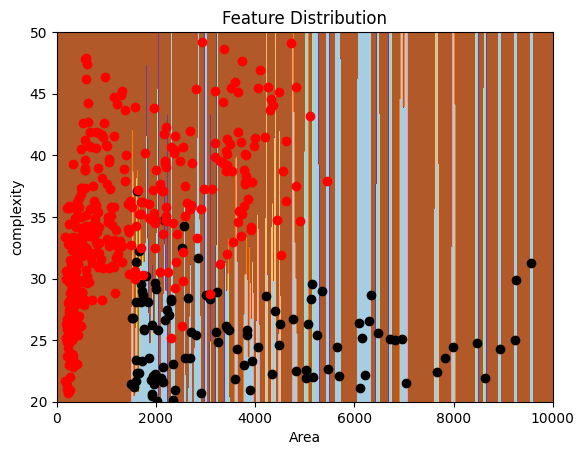

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
subfig = fig.add_subplot(1,1,1)
plt.xlim(0, 10000)
plt.ylim(20, 50)

xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 500),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 500))

Z = best_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

subfig.scatter(car[:,0], car[:,1],color='black')
subfig.scatter(human[:,0], human[:,1],color='red')

subfig.set_title('Feature Distribution')
subfig.set_xlabel('Area')
subfig.set_ylabel('complexity')

plt.savefig("06_graph.png")
plt.show()

## 課題
1. `gamma`の値を大きくするとどうなるか．グラフで確認せよ．
2. 識別率の最も高くなるパラメータを探せ．


## ヒント
1. `gamma=2**-10`(2のマイナス10乗)〜`gamma=2**-15`(2のマイナス15乗)あたりがわかりやすい．これがいわゆる「過学習（Over Fitting）」状態である．
2. パラメータを小さく変更していくと良い．「グリッドサーチ」が導入できると尚良い．興味のある人は調べてみること．

